In [74]:
import pandas as pd
import pymysql.cursors
connection = pymysql.connect(host= 'localhost', user = 'root', password = 'Fulhamfc123$', db= 'project')
cursor = connection.cursor()
sql=('select * from Topic')
Topic = pd.read_sql(sql, connection)

In [75]:
import os 
os.getcwd()

'C:\\Users\\HP'

In [76]:
os.chdir(r'C:\\Users\\HP')
os.getcwd()

'C:\\Users\\HP'

In [77]:
Topic.head()

,id,host_is_superhost,comments
0,163941,f,The apartment was easy to find thanks to mapqu...
1,163941,f,Terry has been absosultely wonderfull througho...
2,163941,f,"nice apartment, perfect for 4 people. clean an..."
3,163941,f,I did not had a chance to meet Terry in-person...
4,163941,f,"Terry was great! Extremely accommodating, and..."


In [78]:
Topic = pd.DataFrame(Topic)

In [79]:
Topic.head()

,id,host_is_superhost,comments
0,163941,f,The apartment was easy to find thanks to mapqu...
1,163941,f,Terry has been absosultely wonderfull througho...
2,163941,f,"nice apartment, perfect for 4 people. clean an..."
3,163941,f,I did not had a chance to meet Terry in-person...
4,163941,f,"Terry was great! Extremely accommodating, and..."


In [80]:
import numpy as np
import pandas as pd
import re, nltk, spacy, gensim
import en_core_web_sm
nlp = en_core_web_sm.load()

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline
dler = nltk.downloader.Downloader()
dler._update_index()
dler.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [81]:
data = Topic['comments'].values.tolist()
# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

print(data[:3])

['The apartment was easy to find thanks to mapquest. It was lovely, comfortable and immaculate. Very close to subway and to the Boston Museum of Fine Arts. Terry was available only by phone but ready to help and we found all we needed. Thank you. ', 'Terry has been absosultely wonderfull throughout our stay in Boston. He welcomed us, provided us with information about the citys sights and has been very attentive and easy to reach. We will defintely come back to his place again!', 'nice apartment, perfect for 4 people. clean and very well priced. also very close to the subway station (orange line). would come again!']


In [82]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['the', 'apartment', 'was', 'easy', 'to', 'find', 'thanks', 'to', 'mapquest', 'it', 'was', 'lovely', 'comfortable', 'and', 'immaculate', 'very', 'close', 'to', 'subway', 'and', 'to', 'the', 'boston', 'museum', 'of', 'fine', 'arts', 'terry', 'was', 'available', 'only', 'by', 'phone', 'but', 'ready', 'to', 'help', 'and', 'we', 'found', 'all', 'we', 'needed', 'thank', 'you']]


In [83]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# Run in terminal: python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:2])

['apartment be easy find thank mapquest be lovely comfortable immaculate very close subway boston museum fine art terry be available only phone ready help find need thank', 'terry have be absosultely wonderfull  stay boston welcome provide information citys sight have be very attentive easy reach will defintely come back  place again']


In [84]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(data_lemmatized)

In [85]:
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  0.7124791007047311 %


In [86]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_components=10,               # Number of topics
                                      max_iter=5,               # Max learning iterations
                                      learning_method='batch',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=5, mean_change_tol=0.001,
             n_components=10, n_jobs=-1, n_topics=None, perp_tol=0.1,
             random_state=100, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)


In [87]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -2798597.0077618957
Perplexity:  554.661966583089
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'batch',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 5,
 'mean_change_tol': 0.001,
 'n_components': 10,
 'n_jobs': -1,
 'n_topics': None,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [88]:
# Define Search Param
search_params = {'n_components': [10, 15], 'learning_decay': [.5]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

C:\Users\HP\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\HP\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warnin

GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_components': [10, 15], 'learning_decay': [0.5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [89]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 10}
Best Log Likelihood Score:  -1016731.1938915586
Model Perplexity:  667.7479522710589


In [90]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(10)]

# index names
docnames = ["Doc" + str(i) for i in range(len(data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
Doc0,0.01,0.01,0.01,0.46,0.01,0.01,0.01,0.01,0.16,0.34,3
Doc1,0.01,0.01,0.01,0.01,0.01,0.21,0.01,0.01,0.01,0.73,9
Doc2,0.01,0.01,0.01,0.19,0.01,0.01,0.01,0.01,0.01,0.75,9
Doc3,0,0,0,0,0.15,0.05,0,0,0.49,0.29,8
Doc4,0.53,0.01,0.01,0.26,0.01,0.16,0.01,0.01,0.01,0.01,0
Doc5,0.44,0,0,0.13,0,0.21,0,0,0.2,0,0
Doc6,0.01,0.01,0.01,0.54,0.01,0.01,0.01,0.01,0.01,0.36,3
Doc7,0.28,0.01,0.01,0.31,0.01,0.01,0.01,0.01,0.01,0.37,9
Doc8,0.25,0,0,0.2,0.06,0.16,0,0,0,0.31,9
Doc9,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.89,9


In [99]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,5,4378
1,3,3626
2,0,3563
3,9,3419
4,6,2255
5,4,1652
6,2,595
7,8,589
8,7,298
9,1,247


In [92]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

C:\Users\HP\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
5       29.322565  -16.802166       1        1  16.358983
3       50.317318  140.050400       2        1  15.198513
0      -35.431934  111.669792       3        1  13.982874
4       39.225796   57.173756       4        1  13.333541
9      125.584061   90.116463       5        1  13.211616
6      103.975616  -71.299164       6        1   8.312032
8      -57.040215  -49.743279       7        1   7.159549
1      117.417709    9.055517       8        1   5.989282
2      -48.866684   31.315454       9        1   3.599237
7       18.225489  -99.677864      10        1   2.854373, topic_info=     Category          Freq          Term         Total  loglift  logprob
term                                                                     
1082  Default  12173.000000         great  12173.000000  30.0000  30.0000
1806  Default  12233.000000         place  12233.000000  29.0000  29.0000
1433  Default   7431.000000      location   7431.000000  28.0000  28.0000
112   Default   6021.000000     apartment   6021.000000  27.0000  27.0000
2292  Default  12225.000000          stay  12225.000000  26.0000  26.0000
413   Default   3057.000000         check   3057.000000  25.0000  25.0000
1626  Default   4380.000000          nice   4380.000000  24.0000  24.0000
2067  Default   4126.000000          room   4126.000000  23.0000  23.0000
453   Default   3709.000000         close   3709.000000  22.0000  22.0000
287   Default   8056.000000        boston   8056.000000  21.0000  21.0000
1178  Default   2421.000000          home   2421.000000  20.0000  20.0000
1191  Default   5375.000000          host   5375.000000  19.0000  19.0000
2614  Default   3889.000000          walk   3889.000000  18.0000  18.0000
1483  Default   3172.000000          make   3172.000000  17.0000  17.0000
1760  Default   3218.000000       perfect   3218.000000  16.0000  16.0000
70    Default   1863.000000       airport   1863.000000  15.0000  15.0000
444   Default   7484.000000         clean   7484.000000  14.0000  14.0000
1199  Default   2667.000000         house   2667.000000  13.0000  13.0000
770   Default   3997.000000          easy   3997.000000  12.0000  12.0000
1977  Default   4099.000000     recommend   4099.000000  11.0000  11.0000
86    Default   1651.000000       amazing   1651.000000  10.0000  10.0000
2246  Default   2428.000000         space   2428.000000   9.0000   9.0000
223   Default   1462.000000      bathroom   1462.000000   8.0000   8.0000
2040  Default   2406.000000    restaurant   2406.000000   7.0000   7.0000
2217  Default    931.000000         snack    931.000000   6.0000   6.0000
2289  Default   1442.000000       station   1442.000000   5.0000   5.0000
1960  Default   2917.000000        really   2917.000000   4.0000   4.0000
307   Default   1023.000000        brenda   1023.000000   3.0000   3.0000
1927  Default   1112.000000      question   1112.000000   2.0000   2.0000
480   Default   4004.000000   comfortable   4004.000000   1.0000   1.0000
...       ...           ...           ...           ...      ...      ...
2160  Topic10    199.436080         sheet    200.403961   3.5515  -4.1494
2039  Topic10    196.507119          rest    197.475076   3.5514  -4.1642
368   Topic10    173.069060          casa    174.036783   3.5507  -4.2912
1029  Topic10    172.772046        garden    173.739918   3.5507  -4.2929
2454  Topic10    160.696149          todo    161.663870   3.5503  -4.3653
722   Topic10    152.832271           dog    153.800194   3.5500  -4.4155
1728  Topic10    150.667727          para    151.635447   3.5499  -4.4298
473   Topic10    145.331342       college    146.299228   3.5497  -4.4658
978   Topic10    144.635541        forget    145.603546   3.5496  -4.4706
769   Topic10    143.750814          east    144.718816   3.5496  -4.4768
388   Topic10    142.399088        cereal    143.367204   3.5495  -4.4862
1302 

In [230]:
data_frame = pd.concat([df_document_topic.reset_index(drop=True), Topic], axis=1)
del data_frame['comments']
data_frame.head()
data_frame['host_is_superhost'] = data_frame['host_is_superhost'].replace({'f': 'Host', 't': 'Superhost'})

data_compute = data_frame.groupby(['id','host_is_superhost']).agg(np.mean)
data_compute = data_compute.reset_index(level=['host_is_superhost'])

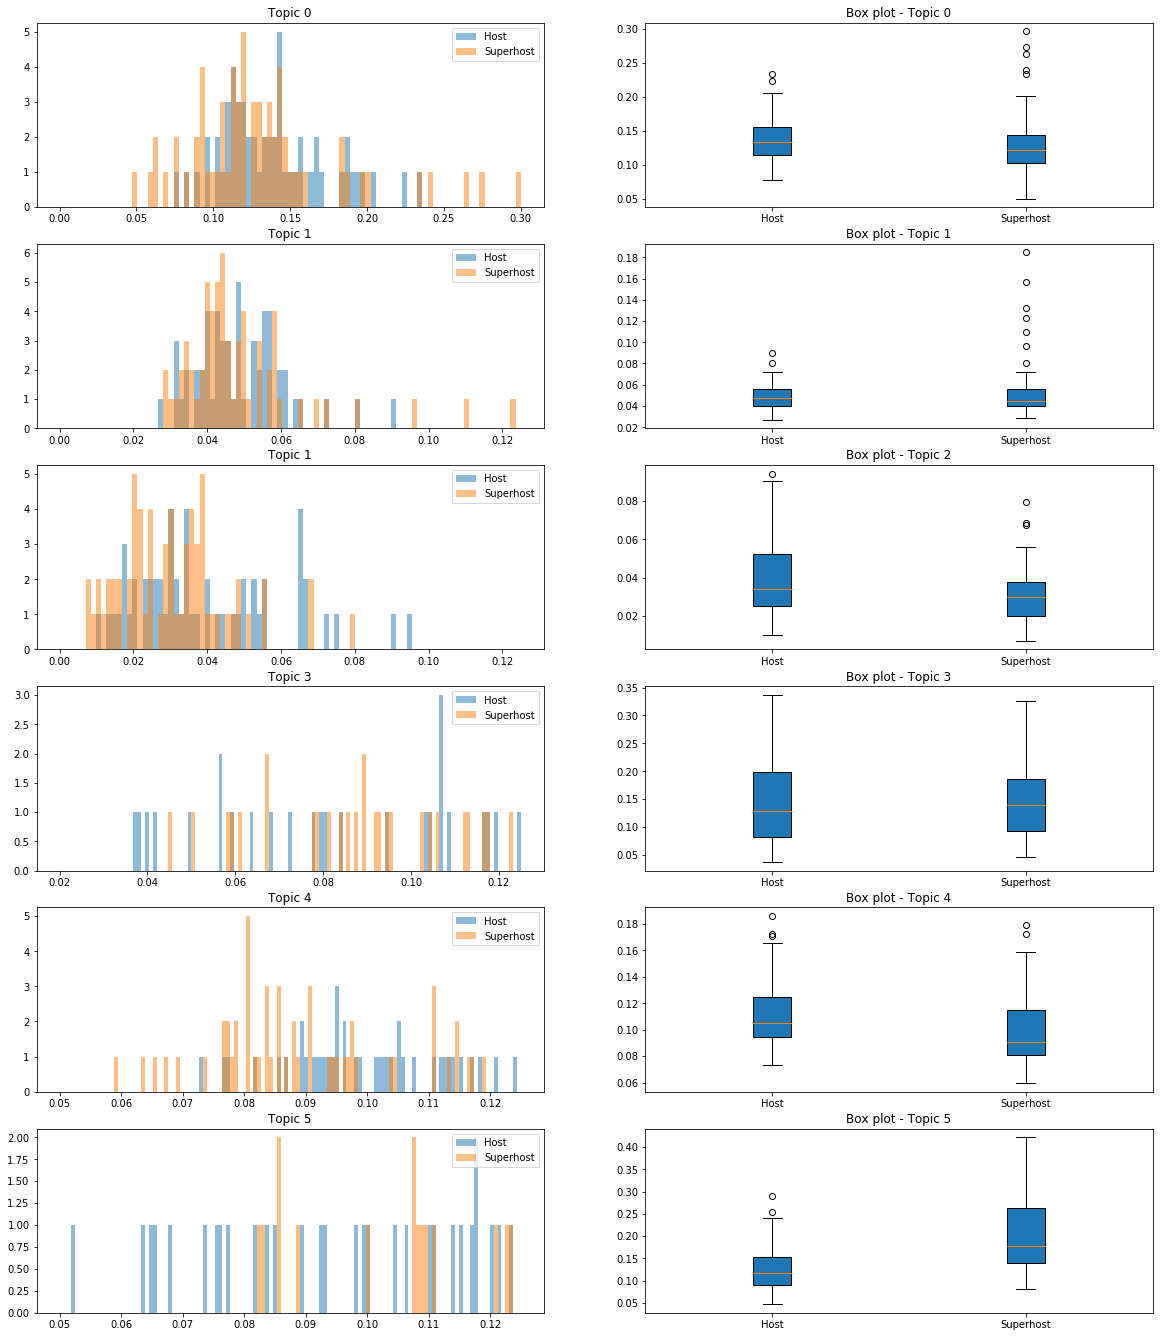

In [233]:
import matplotlib.pyplot as pyplot
fig_size[0] = 20
fig_size[1] = 40
plt.rcParams["figure.figsize"] = fig_size
############## Topic 0
pyplot.subplot(10,2,1)
l1 = []
l2 = []
l1 = data_compute[data_compute['host_is_superhost'] == 'Host']['Topic0'].values.tolist()
l2 = data_compute[data_compute['host_is_superhost'] == 'Superhost']['Topic0'].values.tolist()
bins = numpy.linspace(-0.0, 0.30, 90)
pyplot.hist(l1, bins, alpha=0.5, label='Host')
pyplot.hist(l2, bins, alpha=0.5, label='Superhost')
pyplot.legend(loc='upper right')
matplotlib.pyplot.title("Topic 0",  loc='center')

#pyplot.show() 
matplotlib.pyplot.title("Topic 0",  loc='center')

pyplot.subplot(10,2,2)
box_plot_data = [l1, l2]
plt.boxplot(box_plot_data,patch_artist=True,labels=['Host','Superhost'])
matplotlib.pyplot.title("Box plot - Topic 0",  loc='center')
#pyplot.show() 


########## Topic 1
pyplot.subplot(10,2,3)

l3 = []
l4 = []
l3 = data_compute[data_compute['host_is_superhost'] == 'Host']['Topic1'].values.tolist()
l4 = data_compute[data_compute['host_is_superhost'] == 'Superhost']['Topic1'].values.tolist()
bins = numpy.linspace(-0.0, 0.125, 90)
pyplot.hist(l3, bins, alpha=0.5, label='Host')
pyplot.hist(l4, bins, alpha=0.5, label='Superhost')
pyplot.legend(loc='upper right')
matplotlib.pyplot.title("Topic 1",  loc='center')
#pyplot.show() 

pyplot.subplot(10,2,4)
box_plot_data = [l3, l4]
plt.boxplot(box_plot_data,patch_artist=True,labels=['Host','Superhost'])
matplotlib.pyplot.title("Box plot - Topic 1",  loc='center')
#pyplot.show()
# Get current size
fig_size = plt.rcParams["figure.figsize"]
 
########## Topic 2
pyplot.subplot(10,2,5)

l5 = []
l6 = []
l5 = data_compute[data_compute['host_is_superhost'] == 'Host']['Topic2'].values.tolist()
l6 = data_compute[data_compute['host_is_superhost'] == 'Superhost']['Topic2'].values.tolist()
bins = numpy.linspace(-0.0, 0.125, 90)
pyplot.hist(l5, bins, alpha=0.5, label='Host')
pyplot.hist(l6, bins, alpha=0.5, label='Superhost')
pyplot.legend(loc='upper right')
matplotlib.pyplot.title("Topic 1",  loc='center')
#pyplot.show() 

pyplot.subplot(10,2,6)
box_plot_data = [l5, l6]
plt.boxplot(box_plot_data,patch_artist=True,labels=['Host','Superhost'])
matplotlib.pyplot.title("Box plot - Topic 2",  loc='center')
#pyplot.show()
# Get current size
fig_size = plt.rcParams["figure.figsize"]

################### Topic 3
pyplot.subplot(10,2,7)

l7 = []
l8 = []
l7 = data_compute[data_compute['host_is_superhost'] == 'Host']['Topic3'].values.tolist()
l8 = data_compute[data_compute['host_is_superhost'] == 'Superhost']['Topic3'].values.tolist()
bins = numpy.linspace(0.02, 0.125, 120)
pyplot.hist(l7, bins, alpha=0.5, label='Host')
pyplot.hist(l8, bins, alpha=0.5, label='Superhost')
pyplot.legend(loc='upper right')
matplotlib.pyplot.title("Topic 3",  loc='center')
#pyplot.show() 

pyplot.subplot(10,2,8)
box_plot_data = [l7, l8]
plt.boxplot(box_plot_data,patch_artist=True,labels=['Host','Superhost'])
matplotlib.pyplot.title("Box plot - Topic 3",  loc='center')
#pyplot.show()
# Get current size
fig_size = plt.rcParams["figure.figsize"]

################### Topic 4
pyplot.subplot(10,2,9)

l8 = []
l9 = []
l8 = data_compute[data_compute['host_is_superhost'] == 'Host']['Topic4'].values.tolist()
l9 = data_compute[data_compute['host_is_superhost'] == 'Superhost']['Topic4'].values.tolist()
bins = numpy.linspace(0.05, 0.125, 120)
pyplot.hist(l8, bins, alpha=0.5, label='Host')
pyplot.hist(l9, bins, alpha=0.5, label='Superhost')
pyplot.legend(loc='upper right')
matplotlib.pyplot.title("Topic 4",  loc='center')
#pyplot.show() 

pyplot.subplot(10,2,10)
box_plot_data = [l8, l9]
plt.boxplot(box_plot_data,patch_artist=True,labels=['Host','Superhost'])
matplotlib.pyplot.title("Box plot - Topic 4",  loc='center')
#pyplot.show()
# Get current size
fig_size = plt.rcParams["figure.figsize"]

#pyplot.show()

################### Topic 5
pyplot.subplot(10,2,11)

l10 = []
l11 = []
l10 = data_compute[data_compute['host_is_superhost'] == 'Host']['Topic5'].values.tolist()
l11 = data_compute[data_compute['host_is_superhost'] == 'Superhost']['Topic5'].values.tolist()
bins = numpy.linspace(0.05, 0.125, 120)
pyplot.hist(l10, bins, alpha=0.5, label='Host')
pyplot.hist(l11, bins, alpha=0.5, label='Superhost')
pyplot.legend(loc='upper right')
matplotlib.pyplot.title("Topic 5",  loc='center')
#pyplot.show() 

pyplot.subplot(10,2,12)
box_plot_data = [l10, l11]
plt.boxplot(box_plot_data,patch_artist=True,labels=['Host','Superhost'])
matplotlib.pyplot.title("Box plot - Topic 5",  loc='center')
#pyplot.show()
# Get current size
fig_size = plt.rcParams["figure.figsize"]

pyplot.show()

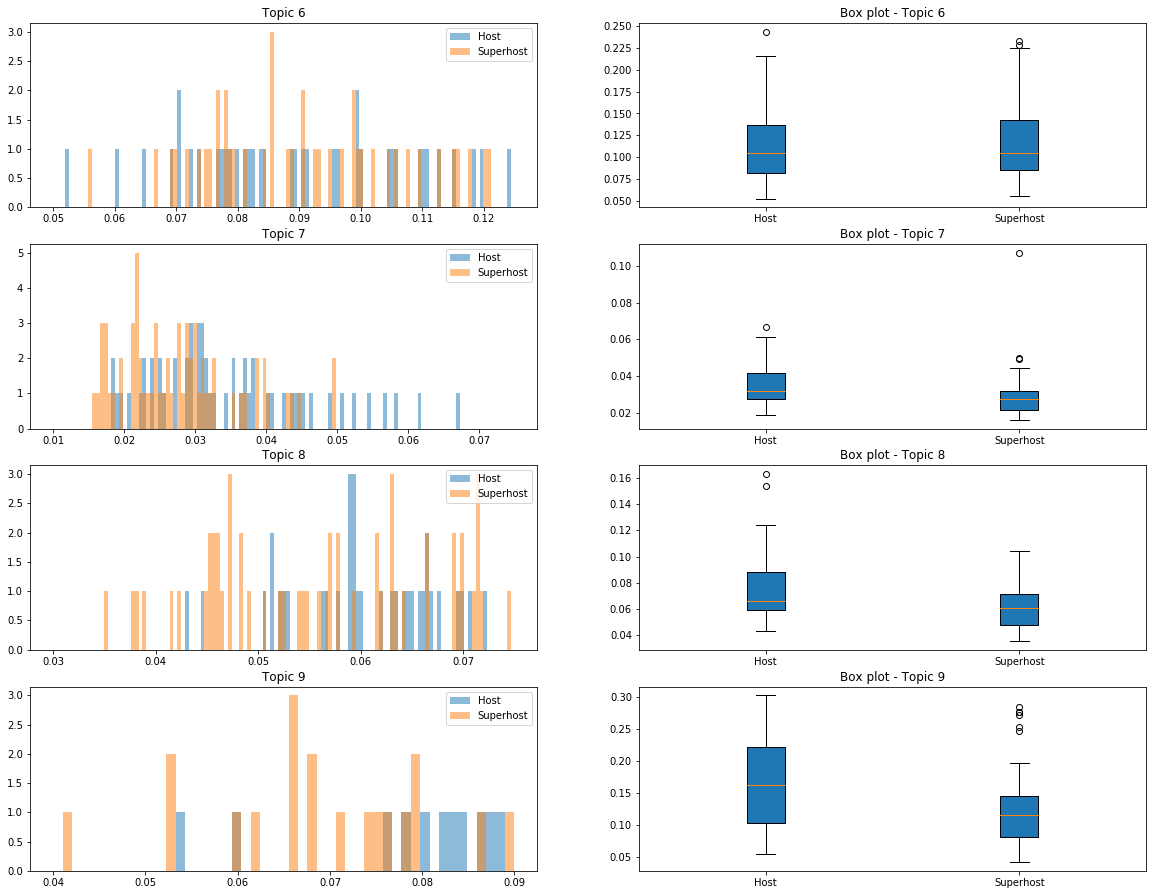

In [249]:
fig_size[0] = 20
fig_size[1] = 40
plt.rcParams["figure.figsize"] = fig_size
################### Topic 6
pyplot.subplot(10,2,13)

l12 = []
l13 = []
l12 = data_compute[data_compute['host_is_superhost'] == 'Host']['Topic6'].values.tolist()
l13 = data_compute[data_compute['host_is_superhost'] == 'Superhost']['Topic6'].values.tolist()
bins = numpy.linspace(0.05, 0.125, 120)
pyplot.hist(l12, bins, alpha=0.5, label='Host')
pyplot.hist(l13, bins, alpha=0.5, label='Superhost')
pyplot.legend(loc='upper right')
matplotlib.pyplot.title("Topic 6",  loc='center')
#pyplot.show() 

pyplot.subplot(10,2,14)
box_plot_data = [l12, l13]
plt.boxplot(box_plot_data,patch_artist=True,labels=['Host','Superhost'])
matplotlib.pyplot.title("Box plot - Topic 6",  loc='center')
#pyplot.show()
# Get current size
fig_size = plt.rcParams["figure.figsize"]

################### Topic 7
pyplot.subplot(10,2,15)

l14 = []
l15 = []
l14 = data_compute[data_compute['host_is_superhost'] == 'Host']['Topic7'].values.tolist()
l15 = data_compute[data_compute['host_is_superhost'] == 'Superhost']['Topic7'].values.tolist()
bins = numpy.linspace(0.01, 0.075, 120)
pyplot.hist(l14, bins, alpha=0.5, label='Host')
pyplot.hist(l15, bins, alpha=0.5, label='Superhost')
pyplot.legend(loc='upper right')
matplotlib.pyplot.title("Topic 7",  loc='center')
#pyplot.show() 

pyplot.subplot(10,2,16)
box_plot_data = [l14, l15]
plt.boxplot(box_plot_data,patch_artist=True,labels=['Host','Superhost'])
matplotlib.pyplot.title("Box plot - Topic 7",  loc='center')
#pyplot.show()
# Get current size
fig_size = plt.rcParams["figure.figsize"]

################### Topic 8
pyplot.subplot(10,2,17)

l16 = []
l17 = []
l16 = data_compute[data_compute['host_is_superhost'] == 'Host']['Topic8'].values.tolist()
l17 = data_compute[data_compute['host_is_superhost'] == 'Superhost']['Topic8'].values.tolist()
bins = numpy.linspace(0.03, 0.075, 120)
pyplot.hist(l16, bins, alpha=0.5, label='Host')
pyplot.hist(l17, bins, alpha=0.5, label='Superhost')
pyplot.legend(loc='upper right')
matplotlib.pyplot.title("Topic 8",  loc='center')
#pyplot.show() 

pyplot.subplot(10,2,18)
box_plot_data = [l16, l17]
plt.boxplot(box_plot_data,patch_artist=True,labels=['Host','Superhost'])
matplotlib.pyplot.title("Box plot - Topic 8",  loc='center')
#pyplot.show()
# Get current size
fig_size = plt.rcParams["figure.figsize"]

################### Topic 9
pyplot.subplot(10,2,19)

l18 = []
l19 = []
l18 = data_compute[data_compute['host_is_superhost'] == 'Host']['Topic9'].values.tolist()
l19 = data_compute[data_compute['host_is_superhost'] == 'Superhost']['Topic9'].values.tolist()
bins = numpy.linspace(0.04, 0.09, 50)
pyplot.hist(l18, bins, alpha=0.5, label='Host')
pyplot.hist(l19, bins, alpha=0.5, label='Superhost')
pyplot.legend(loc='upper right')
matplotlib.pyplot.title("Topic 9",  loc='center')
#pyplot.show() 

pyplot.subplot(10,2,20)
box_plot_data = [l18, l19]
plt.boxplot(box_plot_data,patch_artist=True,labels=['Host','Superhost'])
matplotlib.pyplot.title("Box plot - Topic 9",  loc='center')
#pyplot.show()
# Get current size
fig_size = plt.rcParams["figure.figsize"]


pyplot.show()